# Computing Spike Triggered Average from Multi Unit activity

Welcome to the STA from MU notebook.
This notebook can be used to compute a spike triggered average from multi unit responses to a checkerboard stimulus.

To use this notebook, please follow these steps:

**1)** Make a copy of this notebook, rename it with the **date of your experiment**, your **trigram**, and the **experiment number**. e.g. For the first experiment performed by Thomas Buffet on 1st of March 2021, use `20210301_tbt_1`. Leave the copied notebook in the same directory. 

**2)** Export the spikes using MCRack. Make sure that you set the threshold correctly, so that the triggers are exported correctly, otherwise the analysis won't work. For more detail, see the section **Spike extractions with MCRack at the end** of the notebook.

**3)** Modify the parameters in the following cell. This is the **ONLY** cell where you need to change something.

**4)** Run all the cells in order, or click `Cell` > `Run all`

**5)** If you encounter errors, try to fix them, then click `Kernel`>`Restart and clear output` then click `Cell` > `Run all` again.

**Note** : if you have several checkerboards to analyse for the same experiment, create a new notebook for each. You can change the name of your analysis in the following cell, in the field `analysis_name`

In [1]:
# >>> HERE MODIFY THE PARAMETERS <<< 

### Basic parameters: they usually need to be changed for each experiment

# Stimulus parameters
stimulus_frequency = 40               # In Hz
nb_checks_by_side = 24                # The number of checks on each side of the checkerboard
setup = 3                             # 1 for MEA1, 2 for MEA2, 3 for optogenetic room

# Data parameters
experiment_name = "20210615_tbt_1"    # This name will be use to save results and figures, and give titles
analysis_name = "checkerboard"        # This name will be use to save results and figures, and give titles

mu_data_path = r".\data_example"       # The name of the folder where the .dat files are saved
mu_data_filename = 'checkerboard'     # The name given to the .dat files (without '_sppa...')

### Advanced parameters: change them only if you know what they are used for

# Analysis parameters
psth_bin_size = .025                  # In seconds. e.g .025 for 25ms bins
sta_temporal_dimension = 21           # Number of frames to include in STA computation

# Results parameters
plot_figures = True                   # If True, the results figures will be ploted at the end of the notebook
print_results = True                  # If True, a summary of the results will be printed at the end of the notebook
save_results_path = r".\logs"          # If not empty, a log of the analysis will be saved in this folder
save_data_path = r".\results"         # If not empty, the analysed data will be saved in this folder as a pickle file
save_figures_path = r".\figures"      # If not empty, the figures will be saved in this folder

### Very advanced parameters: change them only if you use a different version of the checkerboard, or you you are
# installing the code on a different machine

# You should change these parameters only if you use a different version of the checkerboard
nb_checks_x = 0 #51
nb_checks_y = 0 #38
checkerboard_design = "AABACA"                 # "AABACA" for the classic checkerboard
nb_repeated_frames_by_sequence = 600           # 600 for the classic checkerboard
nb_non_repeated_frames_by_sequence = 600       # 600 for the classic checkerboard
binary_source_path = r".\files"
electrode_mapping_path = r".\files"            # Folder where the electrode mapping file is stored. Change only if you saved the notebook in a different folder
reconstructed_stimuli_path = r".\stimuli"
sampling_frequency = 20000



In [2]:
# Create log file if necessary
import datetime
now = '{date:%Y%m%d_%H%M%S}'.format(date=datetime.datetime.now())
log_filepath = r".\logs\{}_{}_log_{}.txt".format(experiment_name,analysis_name,now)
with open(log_filepath,'w') as log:
    log.write("### {}_{}_analysis_MU. {} ###\n\n".format(experiment_name,analysis_name, now))
    
with open(log_filepath,'a') as log:
    log.write("# Experiment parameters\nSetup nb = {}\n\n".format(setup))
    log.write("# Stimulus parameters\nFrequency = {}\nNb checks by side = {}\n\n".format(stimulus_frequency,
                                                                                      nb_checks_by_side))

In [3]:
# Setup paramaters
if setup == 1:
    dmd_polarity = 1
    pixel_size = 2.3
    
if setup == 2:
    dmd_polarity = 1
    pixel_size = 3.5
        
if setup == 3:
    dmd_polarity = -1
    pixel_size = 2.8


In [5]:
# Import or define the useful packages, classes and functions

import os
from tqdm import tqdm
import numpy as np
import matplotlib.gridspec as gds
import matplotlib.pyplot as plt
import pickle

class Checkerboard:

    def __init__(self, nb_checks, binary_source_path, repetitions, triggers):

        assert os.path.isfile(binary_source_path)

        self._nb_checks = nb_checks
        self._binary_source_path = binary_source_path
        self._repetitions = repetitions
        self._triggers = triggers

        self._binary_source_file = open(self._binary_source_path, mode='rb')


    def __exit__(self, exc_type, exc_value, traceback):

        self._input_file.close()

        return

    def get_limits(self):

        return self._triggers.get_limits()

    def get_repetition_limits(self):

        start_trigger_nbs = self._repetitions.get_start_trigger_nbs(condition_nb=0)
        end_trigger_nbs = self._repetitions.get_end_trigger_nbs(condition_nb=0)

        start_sample_nbs = self._triggers.get_sample_nbs(start_trigger_nbs)
        end_sample_nbs = self._triggers.get_sample_nbs(end_trigger_nbs)

        repetition_limits = [
            (start_sample_nb, end_sample_nb)
            for start_sample_nb, end_sample_nb in zip(start_sample_nbs, end_sample_nbs)
        ]

        return repetition_limits

    def get_image_nbs(self, sample_nbs):

        trigger_nbs = self._triggers.get_trigger_nbs(sample_nbs)

        sequence_length = 300  # frames

        image_nbs = np.copy(trigger_nbs)
        for k, trigger_nb in enumerate(trigger_nbs):
            sequence_nb = trigger_nb // sequence_length
            is_in_frozen_sequence = (sequence_nb % 2) == 1
            if is_in_frozen_sequence:
                offset = 0
            else:
                offset = (sequence_nb // 2) * sequence_length
            image_nb = offset + trigger_nb % sequence_length
            image_nbs[k] = image_nb

        return image_nbs

    def _get_bit(self, bit_nb):

        byte_nb = bit_nb // 8
        self._binary_source_file.seek(byte_nb)
        byte = self._binary_source_file.read(1)
        byte = int.from_bytes(byte, byteorder='big')
        bit = (byte & (1 << (bit_nb % 8))) >> (bit_nb % 8)

        return bit

    def get_image_shape(self):

        shape = (self._nb_checks, self._nb_checks)

        return shape

    def get_image(self, image_nb):

        shape = self.get_image_shape()
        image = np.zeros(shape, dtype=np.float)

        for i in range(0, self._nb_checks):
            for j in range(0, self._nb_checks):
                bit_nb = (self._nb_checks * self._nb_checks * image_nb) + (self._nb_checks * i) + j
                bit = self._get_bit(bit_nb)
                if bit == 0:
                    image[i, j] = 1.0
                elif bit == 1:
                    image[i, j] = 0.0
                else:
                    message = "Unexpected bit value: {}".format(bit)
                    raise ValueError(message)

        image = np.flipud(image)
        image = np.fliplr(image)

        return image

    def get_clip_shape(self, nb_images):

        shape = (nb_images,) + self.get_image_shape()

        return shape

    def get_clip(self, reference_image_nb, nb_images):

        shape = self.get_clip_shape(nb_images)
        clip = np.zeros(shape, dtype=np.float)

        for k in range(0, nb_images):
            image_nb = reference_image_nb + (k - (nb_images - 1))
            clip[k] = self.get_image(image_nb)

        return clip
    
def run_minimal_sanity_check(triggers, sampling_rate=20000, maximal_jitter=0.25e-3):
    """

    :param sampling_rate: sampling rate used to acquire the data
    :param maximal_jitter: maximal jitter (in seconds) used to assert if triggers are evenly spaced
    :return:
    """

    # Check trigger statistics.
    inter_triggers = np.diff(triggers)
    inter_trigger_values, inter_trigger_counts = np.unique(inter_triggers, return_counts=True)

    index = np.argmax(inter_trigger_counts)
    inter_trigger_value = inter_trigger_values[index]

    if not np.all(np.abs(inter_trigger_values - inter_trigger_value) <= maximal_jitter * sampling_rate):
        message = "Triggers are not evenly spaced (some missing?)."
        raise UserWarning(message)
    else:
        message = "Triggers minimal sanity check ok."
        print(message)

    return message

def clip_list(input_list, min_value, max_value):
    
    clipped_list = input_list[input_list <= max_value]
    clipped_list = clipped_list[clipped_list >= min_value]
    
    return clipped_list

def restrict_array(array, value_min, value_max):
    array = array[array>=value_min]
    array = array[array<=value_max]
    return array.tolist()

def align_triggers_spikes(triggers, spike_times, sampling_rate=20000):
    # Clip the spike times to the recording time
    trigger_min = np.min(triggers)
    trigger_max = np.max(triggers)
    clipped_spike_times = clip_list(spike_times, trigger_min, trigger_max)

    # Set trigger start times to zero
    triggers_first_time = np.min(triggers)
    triggers = triggers - triggers_first_time

    # Do the same operation on spike times
    new_spike_times = clipped_spike_times - triggers_first_time
    
    # Get the values in seconds
    # new_triggers = triggers/sampling_rate
    # new_spike_times = new_spike_times/sampling_rate
    
    return triggers, new_spike_times

def evaluate_polarity(sta):
    """Separate space and time components."""

    time_width, space_height, space_width = sta.shape[0], sta.shape[1], sta.shape[2]
    rf_shape = (time_width, space_height * space_width)
    rf = np.reshape(sta, rf_shape)

    # # Remove the median.
    # rf_median = np.median(rf)
    # rf = rf - rf_median

    u, s, vh = np.linalg.svd(rf, full_matrices=False)

    time_rf_shape = (time_width,)
    time_rf = np.reshape(u[:, 1], time_rf_shape)  # TODO why 1 instead of 0?
    space_rf_shape = (space_height, space_width)
    space_rf = np.reshape(vh[1, :], space_rf_shape)  # TODO understand why 1 instead of 0?

    # Determine the cell polarity
    if np.abs(np.max(rf) - np.median(rf)) >= np.abs(np.min(rf) - np.median(rf)):
        rf_polarity = 'ON'
    else:
        rf_polarity = 'OFF'
        
    return rf_polarity

def separate_components(sta):
    """Separate space and time components."""

    time_width, space_height, space_width = sta.shape[0], sta.shape[1], sta.shape[2]
    rf_shape = (time_width, space_height * space_width)
    rf = np.reshape(sta, rf_shape)

    # # Remove the median.
    # rf_median = np.median(rf)
    # rf = rf - rf_median

    u, s, vh = np.linalg.svd(rf, full_matrices=False)

    time_rf_shape = (time_width,)
    time_rf = np.reshape(u[:, 1], time_rf_shape)  # TODO why 1 instead of 0?
    space_rf_shape = (space_height, space_width)
    space_rf = np.reshape(vh[1, :], space_rf_shape)  # TODO understand why 1 instead of 0?

    # Determine the cell polarity
    if np.abs(np.max(rf) - np.median(rf)) >= np.abs(np.min(rf) - np.median(rf)):
        rf_polarity = 'ON'
    else:
        rf_polarity = 'OFF'
        
    # Determine the spatial RF polarity
    if np.abs(np.max(space_rf) - np.median(space_rf) >= np.abs(np.min(space_rf) - np.median(space_rf))):
        space_rf_polarity = 'ON'
    else:
        space_rf_polarity = 'OFF'
        
    # Determine the temporal RF polarity
    if np.abs(np.max(time_rf) - np.median(time_rf) >= np.abs(np.min(time_rf) - np.median(time_rf))):
        time_rf_polarity = 'ON'
    else:
        time_rf_polarity = 'OFF'
        
    # Reverse components (if necessary).
    if rf_polarity != space_rf_polarity:
        space_rf = - space_rf
        
    if rf_polarity != time_rf_polarity:
        time_rf = - time_rf

    return time_rf, space_rf

# Load multi unit data

In [6]:
# Dictionnary to store spike data
electrode_data = {}
total_nb_of_spikes = 0
nb_of_electrodes_with_zero_spikes = 0

# Read spike data and store them in the dictionnary
for i in tqdm(range(1,257), desc='Loading multi unit spike data:'):
    if i < 10:
        electrode_number = "0{}".format(i)
    else:
        electrode_number = "{}".format(i)
    
    path = os.path.join(mu_data_path,"{}_sppa0001_{}.dat".format(mu_data_filename,electrode_number))

    spikes = np.genfromtxt(path, skip_header=1)
    
    electrode_data[i] = spikes
    if spikes.shape != ():
        nb_spikes = spikes.shape[0]
        total_nb_of_spikes += nb_spikes
        if nb_spikes == 0:
            nb_of_electrodes_with_zero_spikes += 1
    else:
        nb_of_electrodes_with_zero_spikes += 1
    
# Create a list of the cells numbers
electrodes = list(electrode_data.keys())

text = "Data loaded from files {}\n\n".format(os.path.join(mu_data_path,"{}_sppa0001_X.dat".format(mu_data_filename)))
print(text)
with open(log_filepath,'a') as log:
    log.write(text)

Loading multi unit spike data:: 100%|████████| 256/256 [00:05<00:00, 44.37it/s]

Data loaded from files .\data_example\checkerboard_sppa0001_X.dat




# Load triggers

In [7]:
triggers = electrode_data[127]

In [8]:
# Get the number of triggers
nb_triggers = len(triggers)

# Get the number of complete sequences played
nb_frames_by_sequence = nb_repeated_frames_by_sequence + nb_non_repeated_frames_by_sequence
nb_repetitions = int(nb_triggers/nb_frames_by_sequence)

text = "{} complete checkerboard sequences were played, and will be used for analysis.".format(nb_repetitions)
print(text)
with open(log_filepath,'a') as log:
    log.write("{}\n\n".format(text))

107 complete checkerboard sequences were played, and will be used for analysis.


# Sanity checks for triggers

In [9]:
message = run_minimal_sanity_check(triggers)
with open(log_filepath,'a') as log:
    log.write("{}\n\n".format(message))

Triggers minimal sanity check ok.


### The result of the previous cell should be "Minimal sanity check ok". If not,  you might want to check again your spike extraction process. If it still doesn't work after that, maybe there was an issue with your triggers in the experiment.

In [10]:
triggers_spacings = np.diff(triggers)
mean_trigger_spacing = np.mean(triggers_spacings)
estimated_frequency = int(round(1 / mean_trigger_spacing))
assert estimated_frequency == stimulus_frequency, "The frequency estimated from triggers ({}Hz) is different from the stimulus frequency ({}Hz).\nCheck that you indicated the correct stimulus frequency. Also check that the spike extraction process was performed correctly.".format(estimated_frequency,stimulus_frequency)
text = "Estimated frequency ({}Hz) matches the stimulus frequency ({}Hz)".format(estimated_frequency,stimulus_frequency)
print(text)
with open(log_filepath,'a') as log:
    log.write("{}\n\n".format(text))

Estimated frequency (40Hz) matches the stimulus frequency (40Hz)


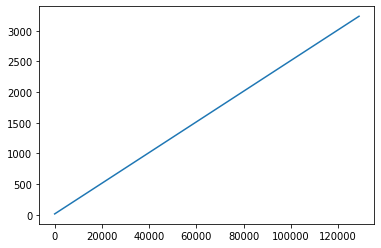

In [11]:
plt.plot(triggers)

### The previous figure should be a straight line. If not, same remarks as above.

# Analysis

In [12]:
analysis_name = "analysis_checkerboard"
analyse = {}

In [13]:
text = "The following parameters will be used for analysis:\n - bin size = {} (for psth)\n- temporal depth= {} frames (for STA)".format(psth_bin_size, sta_temporal_dimension)
print(text)
with open(log_filepath,'a') as log:
    log.write("{}\n\n".format(text))

The following parameters will be used for analysis:
 - bin size = 0.025 (for psth)
- temporal depth= 21 frames (for STA)


## Repeated sequences analysis

In [14]:
for electrode_nb in tqdm(electrodes, desc='Analysing repeated sequences (PSTH)'):
    
    if electrode_nb not in [127,128,255,256]:
    
        # Create a dictionnary entry for this electrode
        analyse[electrode_nb] = {}

        # Get the spikes for this electrode
        spike_times = np.array(electrode_data[electrode_nb])

        # Align triggers and spike times
        aligned_triggers, aligned_spike_times = align_triggers_spikes(triggers, spike_times)

        # Get the repeated sequence times for the specified position
        repeated_sequences_times = []
        for frame in range(0,nb_repetitions*nb_frames_by_sequence,nb_frames_by_sequence):
            times = aligned_triggers[frame+nb_non_repeated_frames_by_sequence:frame+nb_non_repeated_frames_by_sequence+nb_repeated_frames_by_sequence]
            repeated_sequences_times += [[times[0], times[-1]]]

        # Build the spike trains corresponding to stimulus repetitions
        spike_trains = []
        for i in range(len(repeated_sequences_times)):
            spike_train = restrict_array(aligned_spike_times, repeated_sequences_times[i][0], repeated_sequences_times[i][1])
            spike_trains += [spike_train]

        # Align the spike trains
        for i in range(len(spike_trains)):
            spike_trains[i] = spike_trains[i] - repeated_sequences_times[i][0]

        # Compute psth
        duration_repeated_sequence = nb_repeated_frames_by_sequence / stimulus_frequency
        nb_bins = int( duration_repeated_sequence / psth_bin_size)    
        binned_spikes = np.zeros((len(spike_trains), nb_bins))
        for i in range(len(spike_trains)):
            binned_spikes[i,:] = np.histogram(spike_trains[i], bins=nb_bins, range=(0,duration_repeated_sequence))[0]

        binned_spikes = np.sum(binned_spikes, axis=0)

        # Transform spike count in firing rate
        binned_spikes = binned_spikes / nb_repetitions * stimulus_frequency    


        analyse[electrode_nb]["spike_times"] = spike_times
        analyse[electrode_nb]["repeated_sequences_times"] = repeated_sequences_times
        analyse[electrode_nb]["spike_trains"] = spike_trains
        analyse[electrode_nb]["psth"] = binned_spikes

Analysing repeated sequences (PSTH): 100%|███| 256/256 [00:05<00:00, 43.49it/s]


### Sanity check : plot one raster and one PSTH

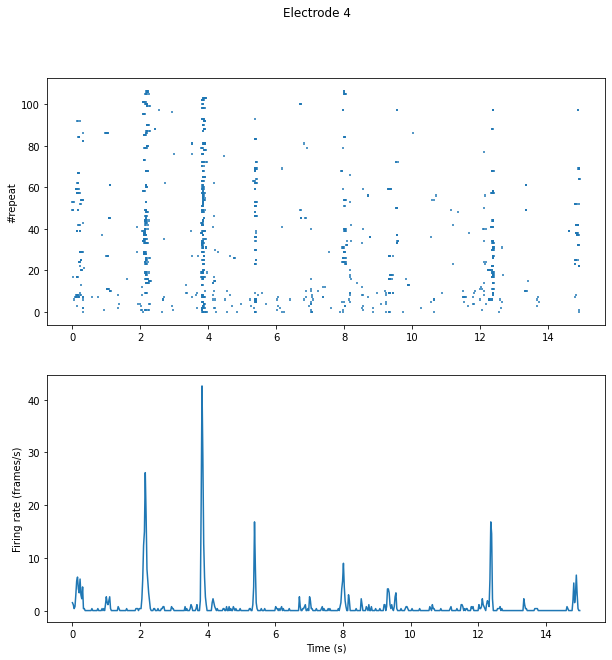

In [15]:
electrode_nb = 4

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plt.suptitle("Electrode {}".format(electrode_nb))

ax = axs[0]
ax.eventplot(analyse[electrode_nb]["spike_trains"])
ax.set_ylabel("#repeat")
# ax.set_xlabel("Time (s)")

ax = axs[1]
ax.plot(np.linspace(0,duration_repeated_sequence, nb_bins), analyse[electrode_nb]["psth"])
ax.set_ylabel("Firing rate (frames/s)")
ax.set_xlabel("Time (s)")


plt.show()

## STA analysis (non repeated sequences)

In [16]:
# Try to load the stimulus from a previously computed one
nb_frames = nb_non_repeated_frames_by_sequence * nb_repetitions
if nb_frames < nb_non_repeated_frames_by_sequence * 100:
    nb_frames = nb_non_repeated_frames_by_sequence * 100
possible_stimulus_path = os.path.join(reconstructed_stimuli_path,"checkerboard_{}checks_{}frames.npy".format(nb_checks_by_side,nb_frames))

if os.path.isfile(possible_stimulus_path):
    checkerboard = np.load(possible_stimulus_path)
    text = "Loaded the stimulus from file checkerboard_{}checks_{}frames.npy".format(nb_checks_by_side, nb_frames)
    print(text)
    with open(log_filepath,'a') as log:
        log.write("{}\n\n".format(text))
    
    
# If not possible, reconstruct the stimulus
    
else:
    checkerboard = np.ones((nb_frames,nb_checks_by_side,nb_checks_by_side), dtype='uint8') 
    binary_source_filepath = os.path.join(binary_source_path,"binarysource1000Mbits")
    assert os.path.isfile(binary_source_filepath)
    checkerboard_object = Checkerboard(nb_checks_by_side, binary_source_filepath, None, None) 
    
    for i in tqdm(range(checkerboard.shape[0]), desc="Reconstruction the stimulus"):
        checkerboard[i,:,:] = checkerboard_object.get_image(i)
        
    filename = "checkerboard_{}checks_{}frames.npy".format(nb_checks_by_side, nb_frames)
    np.save(filename, checkerboard)
    text = "Saved stimulus file {} forlater use".format(filename)
    print(text)
    with open(log_filepath,'a') as log:
        log.write("{}\n\n".format(text))

# Compute the STA for each electrode
for electrode_nb in tqdm(electrodes, desc="Analysing repeated sequences (STA)"):
    
    if electrode_nb not in [127,128,255,256]:
    
        if electrode_nb not in analyse.keys():
            analyse[electrode_nb]={}

        # Get the spike times for this electrode
        spike_times = np.array(electrode_data[electrode_nb])

        # Align triggers and spike times
        aligned_triggers, aligned_spike_times = align_triggers_spikes(triggers, spike_times)

        # Get the repeated sequence times for the specified position
        non_repeated_sequences_times = []
        for i in range(0,nb_repetitions*nb_frames_by_sequence,nb_frames_by_sequence):
            times = aligned_triggers[i:i+nb_non_repeated_frames_by_sequence]
            non_repeated_sequences_times += [[times[0], times[-1]]]

        # Build the spike trains corresponding to stimulus repetitions
        spike_trains = []
        for i in range(len(non_repeated_sequences_times)):
            spike_train = restrict_array(aligned_spike_times, non_repeated_sequences_times[i][0], non_repeated_sequences_times[i][1])
            spike_trains += [spike_train]

        # Align the spike trains
        for i in range(len(spike_trains)):
            spike_trains[i] = spike_trains[i] - non_repeated_sequences_times[i][0]

        # Compute psth
        duration_repeated_sequence = nb_repeated_frames_by_sequence / stimulus_frequency
        nb_bins = nb_repeated_frames_by_sequence
        binned_spikes = np.zeros((len(spike_trains), nb_bins))
        for i in range(len(spike_trains)):
            binned_spikes[i,:] = np.histogram(spike_trains[i], bins=nb_bins, range=(0,duration_repeated_sequence))[0]


        sta = np.zeros((sta_temporal_dimension,nb_checks_by_side,nb_checks_by_side))
        cumulated_spikes = 0

        for repetition in range(nb_repetitions):
            checkerboard_sequence = checkerboard[repetition*nb_non_repeated_frames_by_sequence:(repetition+1)*nb_non_repeated_frames_by_sequence,:,:]
            for timepoint in range(0,sta_temporal_dimension):
                if timepoint ==0:
                    stimulus = checkerboard_sequence.reshape(nb_non_repeated_frames_by_sequence-timepoint,nb_checks_by_side**2)
                else:
                    stimulus = checkerboard_sequence[:-timepoint,:,:].reshape(nb_non_repeated_frames_by_sequence-timepoint,nb_checks_by_side**2)
                response = binned_spikes[repetition,timepoint:]
                sta_tmp = response@stimulus
                sta[timepoint,:,:] += dmd_polarity * sta_tmp.reshape((nb_checks_by_side,nb_checks_by_side))
                cumulated_spikes += np.sum(binned_spikes[repetition,:])

        sta = np.flip(sta, axis=0)

        if setup == 2 or setup ==3:
            sta = np.rot90(np.flip(sta, axis=1), axes=(1,2))

        if cumulated_spikes > 0:
            sta = sta/cumulated_spikes

            time_rf, space_rf = separate_components(sta)

            polarity= evaluate_polarity(sta)
            std_baseline = np.std(time_rf[:10])
            std_peak = np.std(time_rf[-10:])
            ratio = std_peak/std_baseline
            if ratio < 1.5:
                polarity = "NOISE"

        else:
            polarity = "NOISE"



        analyse[electrode_nb]["sta"] = np.flip(sta, axis=0)
        analyse[electrode_nb]["temporal_sta"] = time_rf
        analyse[electrode_nb]["spatial_sta"] = space_rf
        analyse[electrode_nb]["nb_spikes_for_sta"] = int(cumulated_spikes)
        analyse[electrode_nb]["polarity"] = polarity

Analysing repeated sequences (STA):   0%|              | 0/256 [00:00<?, ?it/s]

Loaded the stimulus from file checkerboard_24checks_64200frames.npy


Analysing repeated sequences (STA): 100%|████| 256/256 [10:05<00:00,  2.37s/it]


# Sanity checks

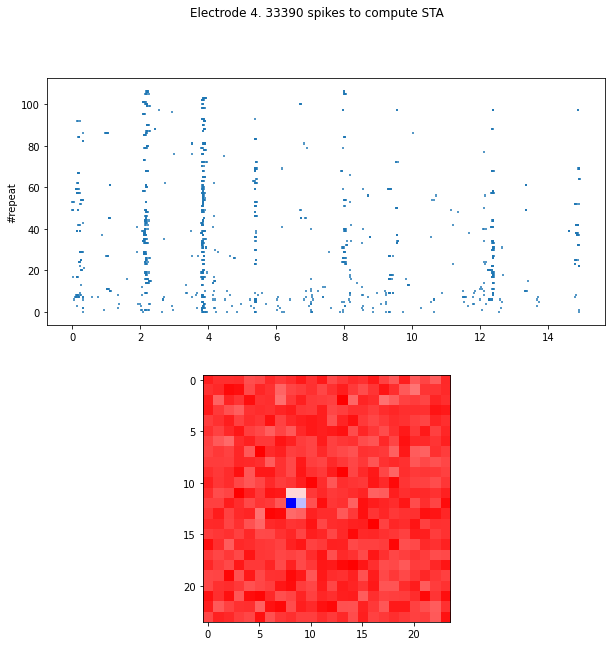

In [17]:
electrode_nb = 4

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plt.suptitle("Electrode {}. {} spikes to compute STA".format(electrode_nb, analyse[electrode_nb]["nb_spikes_for_sta"]))

ax = axs[0]
ax.eventplot(analyse[electrode_nb]["spike_trains"])
ax.set_ylabel("#repeat")
# ax.set_xlabel("Time (s)")

ax = axs[1]
ax.imshow(analyse[electrode_nb]["spatial_sta"], cmap='bwr')

plt.show()

In [18]:
# Save results


# Figures

In [19]:
# Load the MEA electrode mapping
electrode_mapping_filepath = os.path.join(electrode_mapping_path,"electrodes_mapping_MEA_MCS_256")
with open('{}.pickle'.format(electrode_mapping_filepath), 'rb') as handle:
    mapping_electrodes = pickle.load(handle)

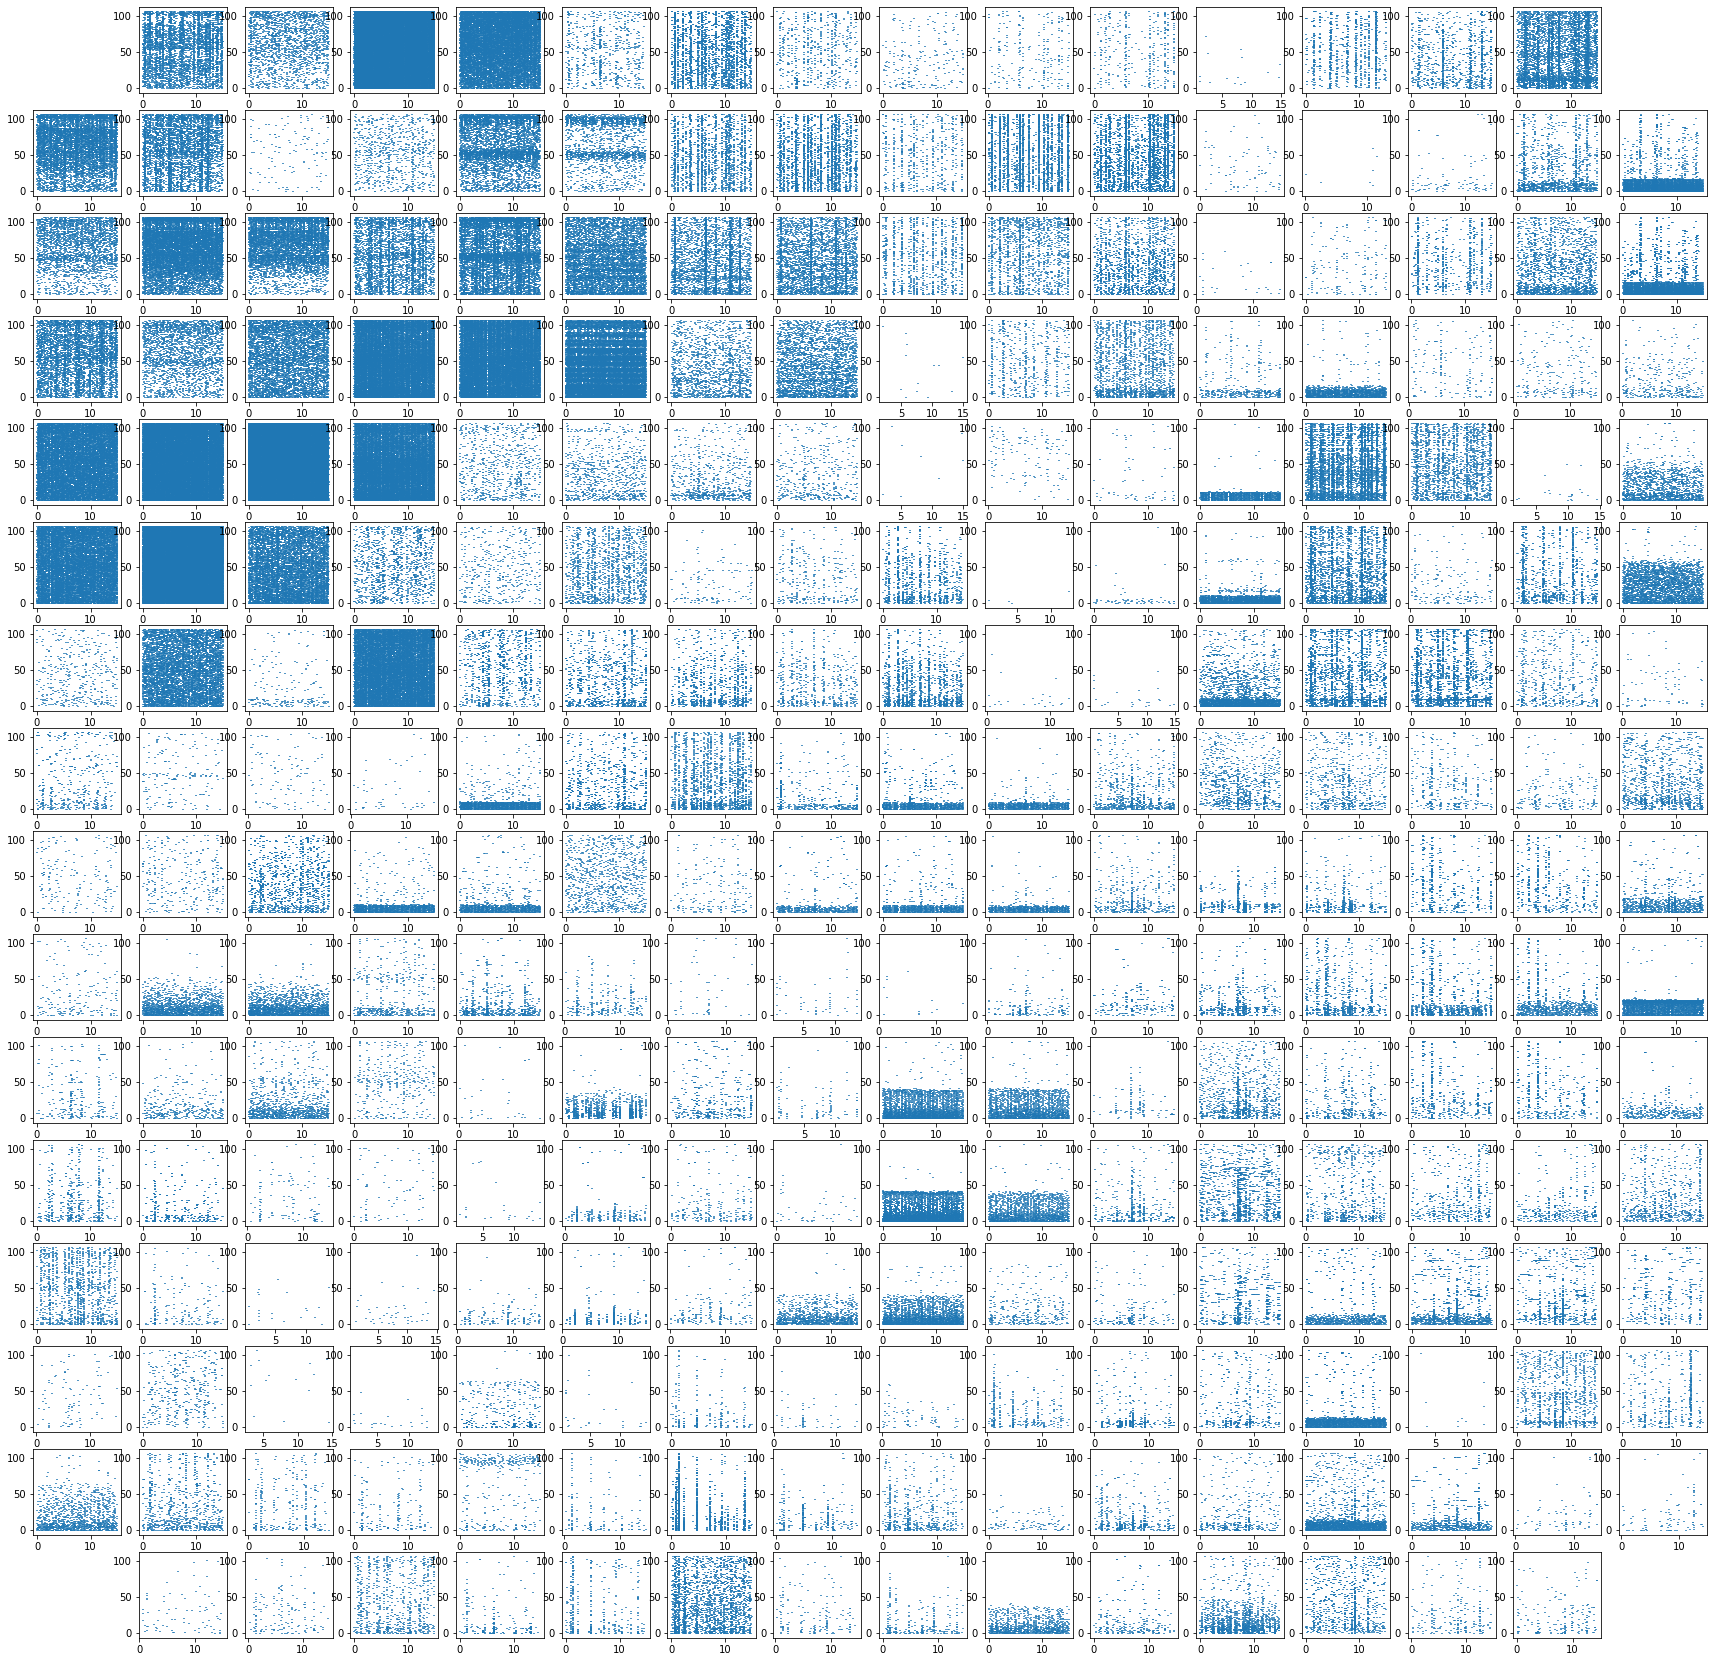

In [20]:
#Plot all the rasters. Takes a few seconds.

fig, axs = plt.subplots(nrows = 16, ncols=16, figsize = (30,30))

for electrode in mapping_electrodes.keys():
    ax = axs[mapping_electrodes[electrode][0], mapping_electrodes[electrode][1]]
    if electrode not in [127,128,255,256]:
        ax.eventplot(analyse[electrode]["spike_trains"])
    else:
        ax.set_visible(False)

            
if save_figures_path != "":
    figure_name = os.path.join(save_figures_path,"{}_{}_rasters_summary".format(experiment_name, analysis_name))
    plt.savefig(figure_name)

if plot_figures:
    plt.show()
else:
    plt.close()

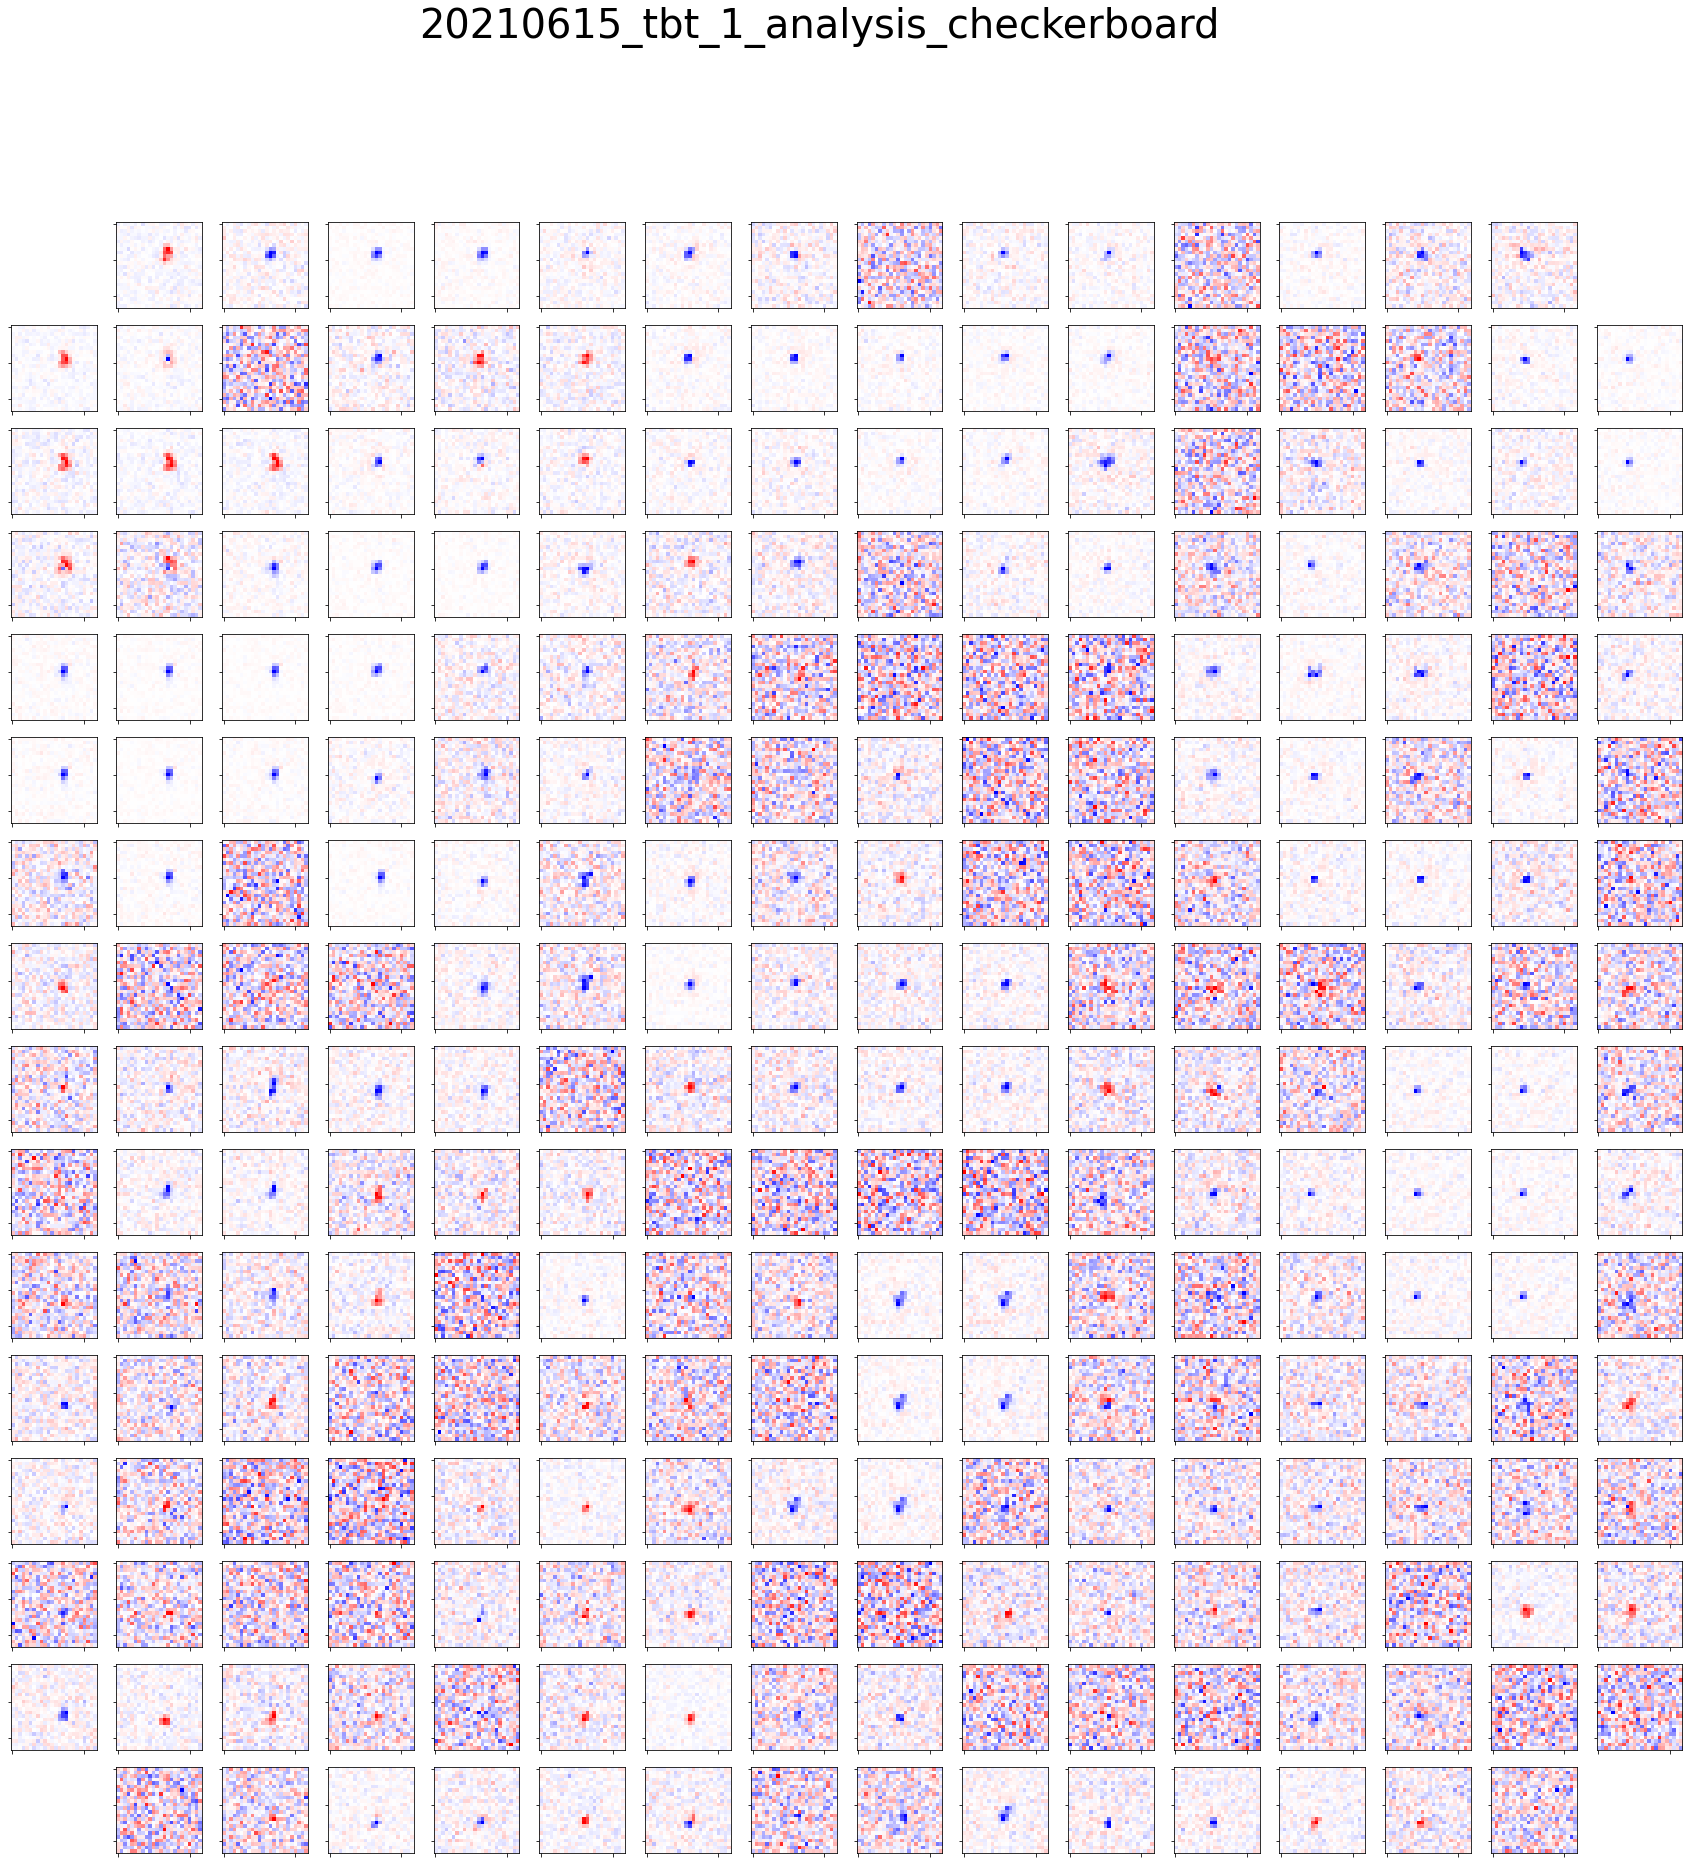

In [21]:
# Plot all the STA spatial profiles. Takes a few seconds.


fig, axs = plt.subplots(nrows = 16, ncols=16, figsize = (30,30))

for electrode in mapping_electrodes.keys():
    ax = axs[mapping_electrodes[electrode][0], mapping_electrodes[electrode][1]]
    if electrode not in [127,128,255,256]:
        max_sta = max(np.max(analyse[electrode]["spatial_sta"]), abs(np.min(analyse[electrode]["spatial_sta"])))
        #if analyse[electrode][recording_name]["polarity"] =="NOISE":
        im = ax.imshow(analyse[electrode]["spatial_sta"], cmap='bwr')
        #else:
        #    im = ax.imshow(np.rot90(analyse[electrode]["checkerboard"]["spatial_sta"]), cmap='bwr')

        im.set_clim(-max_sta, max_sta)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_visible(False)
            
plt.suptitle("{}_{}".format(experiment_name, analysis_name), fontsize=40)
            
if save_figures_path != "":
    figure_name = os.path.join(save_figures_path,"{}_{}_spatial_STAs_summary".format(experiment_name, analysis_name))
    plt.savefig(figure_name)

if plot_figures:
    plt.show()
    
else:
    plt.close()

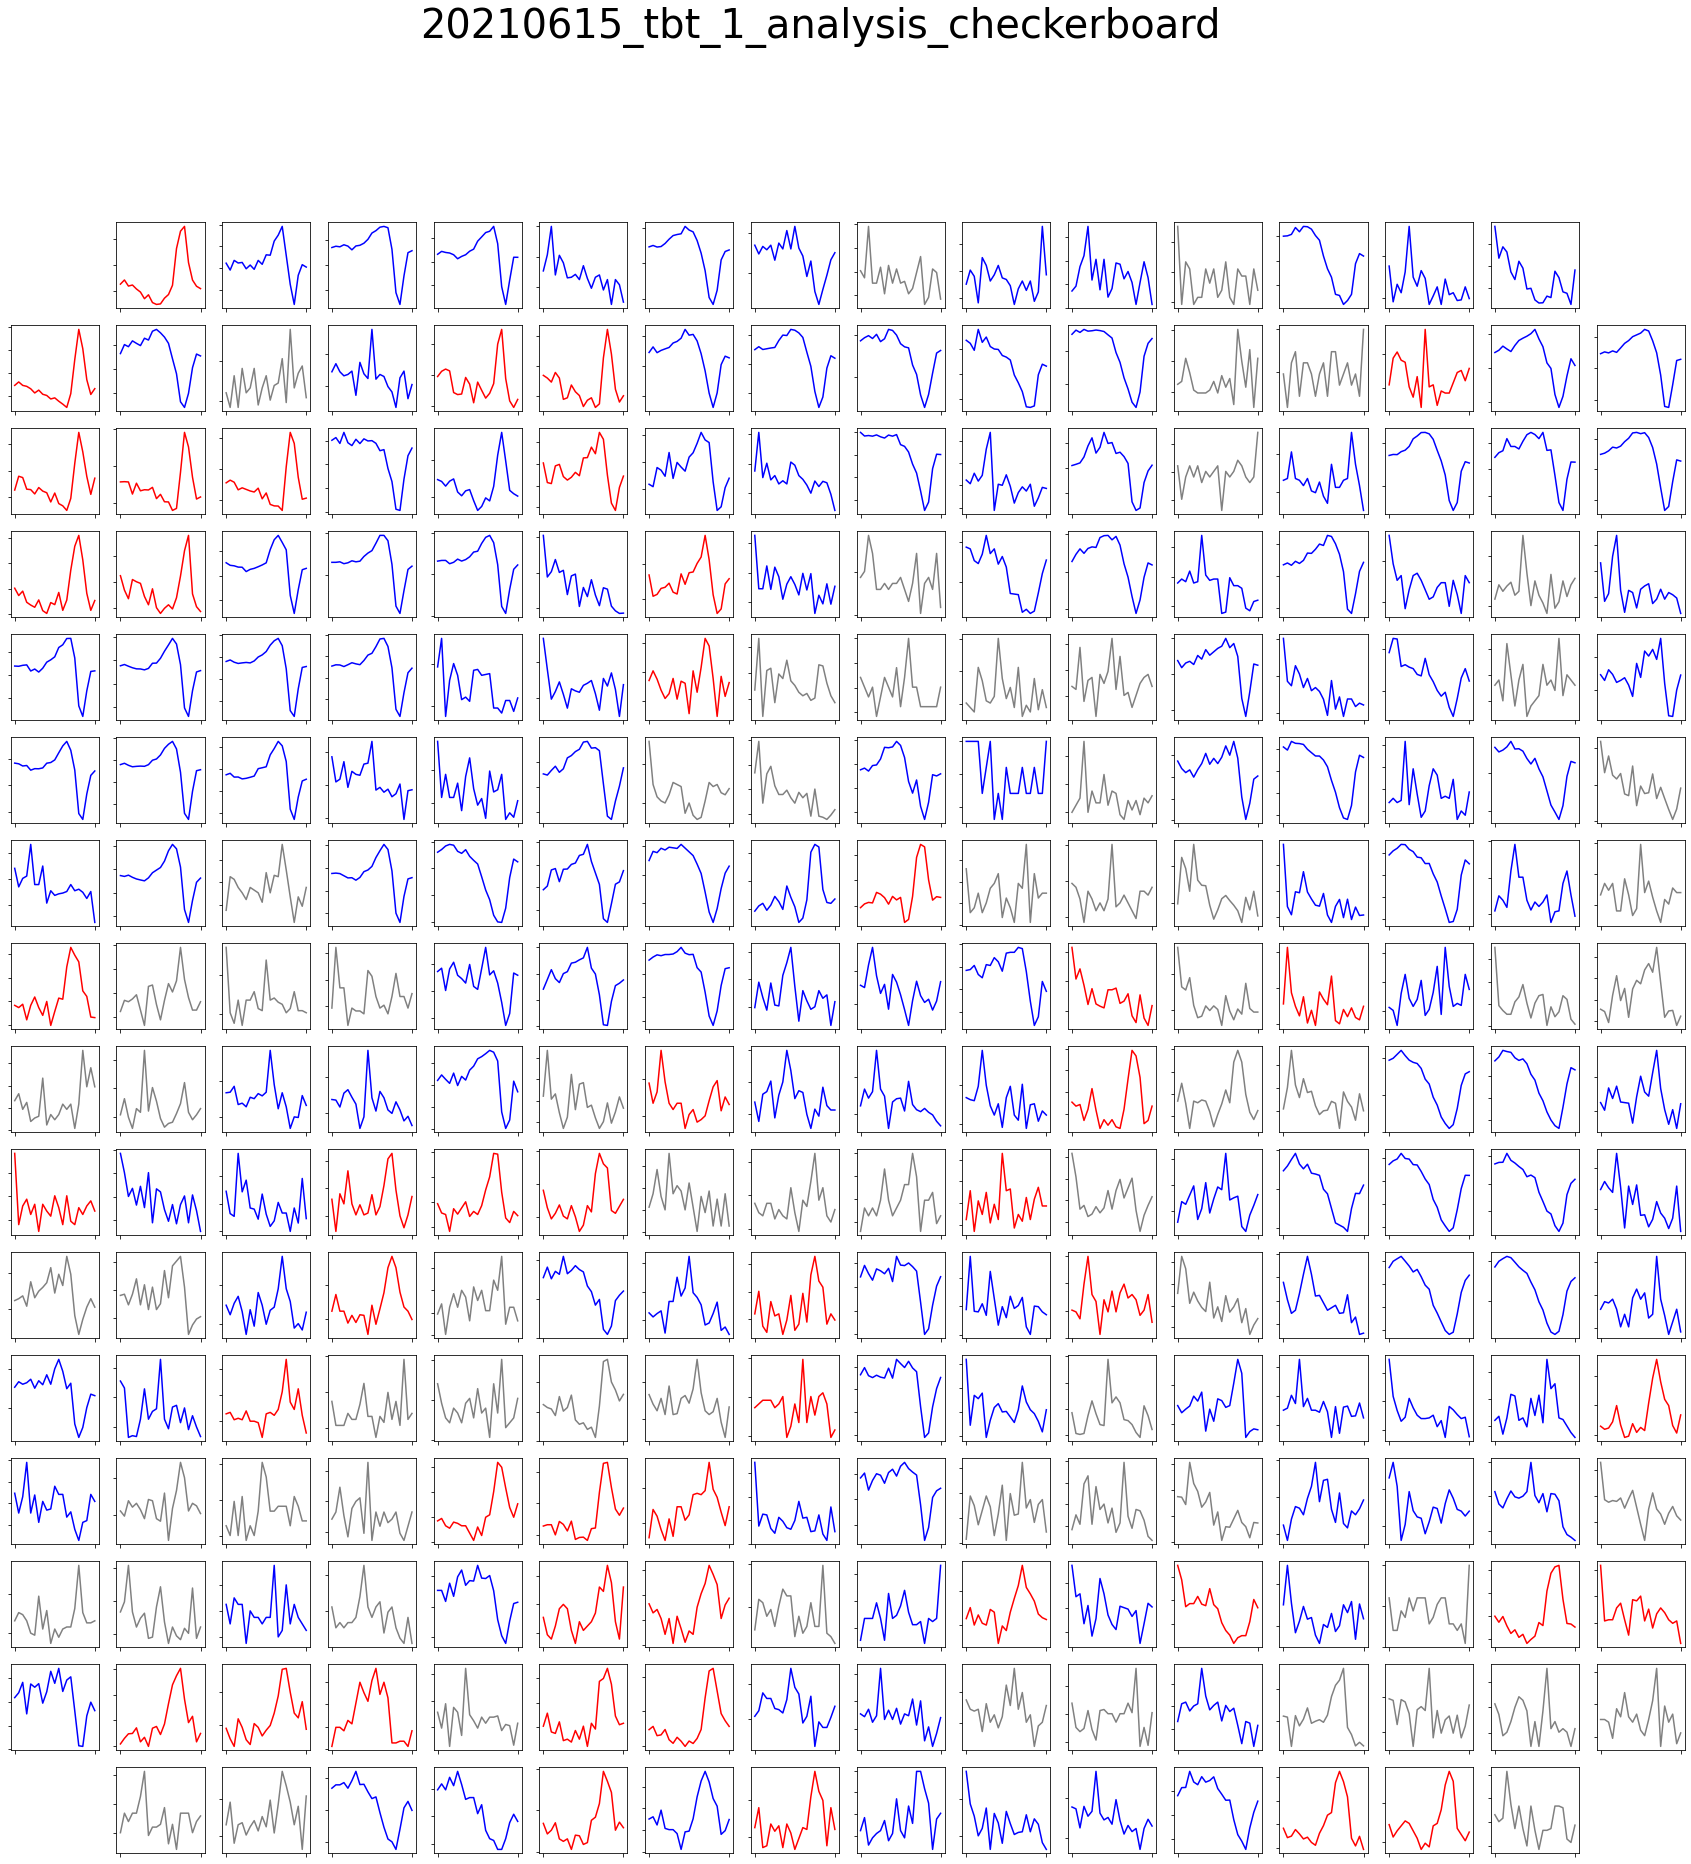

In [22]:
# Plot all the STA temporal profiles. Takes a few seconds.


fig, axs = plt.subplots(nrows = 16, ncols=16, figsize = (30,30))

for electrode in mapping_electrodes.keys():
    ax = axs[mapping_electrodes[electrode][0], mapping_electrodes[electrode][1]]

    if electrode not in [127,128,255,256]:
        sta = analyse[electrode]["sta"]
        max_index = np.unravel_index(np.argmax(sta), sta.shape)[1:]
        temporal_sta = sta[:,max_index[0], max_index[1]]
        if analyse[electrode]["polarity"] =="ON":
            ax.plot(np.flip(temporal_sta), c='r')
        elif analyse[electrode]["polarity"] =="OFF":
            ax.plot(np.flip(temporal_sta), c='b')
        else:
            ax.plot(np.flip(temporal_sta), c='gray')

        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_visible(False)
        
plt.suptitle("{}_{}".format(experiment_name, analysis_name), fontsize=40)

if save_figures_path != "":
    figure_name = os.path.join(save_figures_path,"{}_{}_temporal_STAs_summary".format(experiment_name, analysis_name))
    plt.savefig(figure_name)
        
if plot_figures:
    plt.show()
else:
    plt.close()

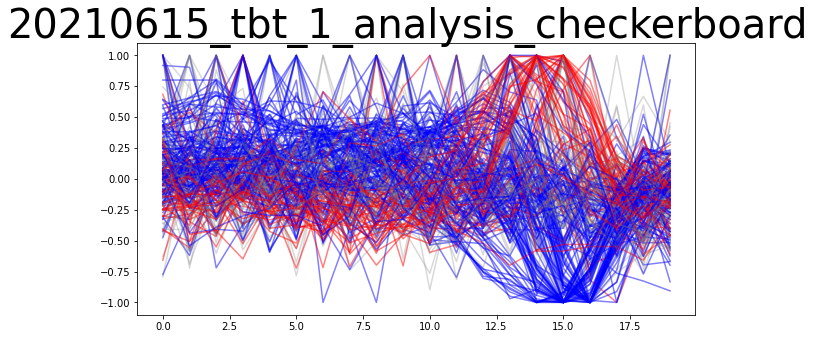

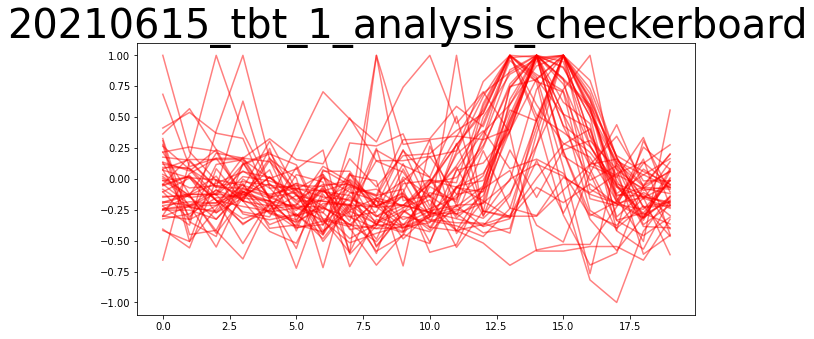

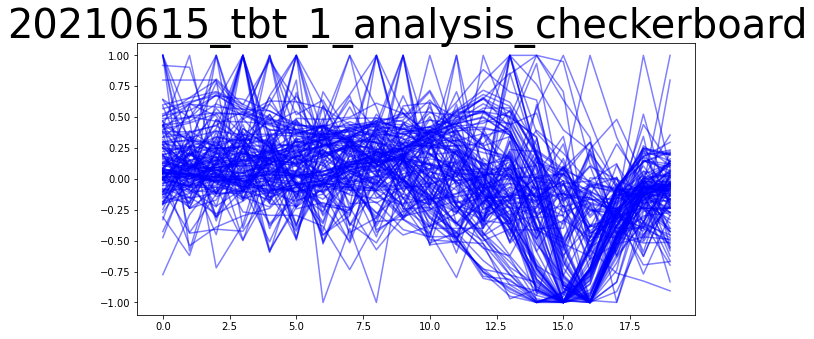

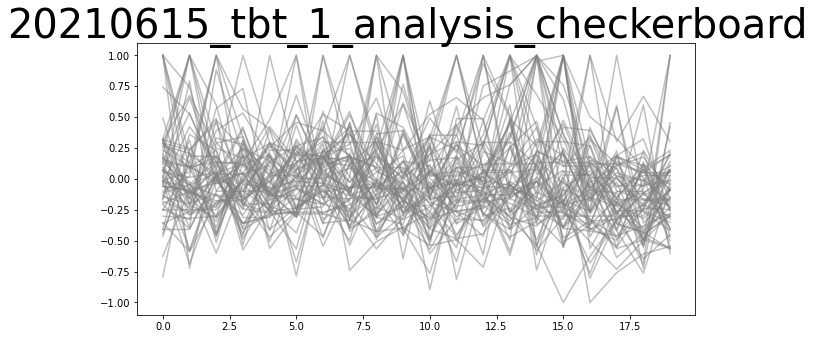

In [23]:
# Plot the STA temporal profiles, sortedby type (ON/OFF/NOISE)

# Plot All
plt.figure(figsize=(10,5))
for cell_nb in mapping_electrodes.keys():
    if cell_nb not in [127,128,255,256]:
        max_index = np.unravel_index(np.argmax(analyse[cell_nb]["sta"]), analyse[cell_nb]["sta"].shape)[1:]
        temporal_sta = analyse[cell_nb]["sta"][:,max_index[0], max_index[1]]
        normalized_temporal_sta = temporal_sta - np.mean(temporal_sta)
        normalized_temporal_sta = normalized_temporal_sta/max(np.max(normalized_temporal_sta), -np.min(normalized_temporal_sta))
        if analyse[cell_nb]["polarity"] == "ON":
            plt.plot(np.flip(normalized_temporal_sta[:20]), c='r', alpha=.5)
            pass
        elif analyse[cell_nb]["polarity"] == "OFF":
            plt.plot(np.flip(normalized_temporal_sta[:20]), c='b', alpha=.5)
            pass
        else:
            plt.plot(np.flip(normalized_temporal_sta[:20]), c='gray', alpha=.3)
        
plt.suptitle("{}_{}".format(experiment_name, analysis_name), fontsize=40)

if save_figures_path != "":
    figure_name = os.path.join(save_figures_path,"{}_{}_temporal_STAs_all".format(experiment_name, analysis_name))
    plt.savefig(figure_name)

if plot_figures:
    plt.show()
else:
    plt.close()

# Plot ON only
plt.figure(figsize=(10,5))
for cell_nb in mapping_electrodes.keys():
    if cell_nb not in [127,128,255,256]:
        max_index = np.unravel_index(np.argmax(analyse[cell_nb]["sta"]), analyse[cell_nb]["sta"].shape)[1:]
        temporal_sta = analyse[cell_nb]["sta"][:,max_index[0], max_index[1]]
        normalized_temporal_sta = temporal_sta - np.mean(temporal_sta)
        normalized_temporal_sta = normalized_temporal_sta/max(np.max(normalized_temporal_sta), -np.min(normalized_temporal_sta))
        if analyse[cell_nb]["polarity"] == "ON":
            plt.plot(np.flip(normalized_temporal_sta[:20]), c='r', alpha=.5)
        
plt.suptitle("{}_{}".format(experiment_name, analysis_name), fontsize=40)

if plot_figures:
    plt.show()
else:
    plt.close()

# Plot OFF only 
plt.figure(figsize=(10,5))
for cell_nb in mapping_electrodes.keys():
    if cell_nb not in [127,128,255,256]:

        max_index = np.unravel_index(np.argmax(analyse[cell_nb]["sta"]), analyse[cell_nb]["sta"].shape)[1:]
        temporal_sta = analyse[cell_nb]["sta"][:,max_index[0], max_index[1]]
        normalized_temporal_sta = temporal_sta - np.mean(temporal_sta)
        normalized_temporal_sta = normalized_temporal_sta/max(np.max(normalized_temporal_sta), -np.min(normalized_temporal_sta))
        if analyse[cell_nb]["polarity"] == "OFF":
            plt.plot(np.flip(normalized_temporal_sta[:20]), c='b', alpha=.5)
        
plt.suptitle("{}_{}".format(experiment_name, analysis_name), fontsize=40)

if plot_figures:
    plt.show()
else:
    plt.close()

# Plot NOISE only
plt.figure(figsize=(10,5))
for cell_nb in mapping_electrodes.keys():
    if cell_nb not in [127,128,255,256]:
        max_index = np.unravel_index(np.argmax(analyse[cell_nb]["sta"]), analyse[cell_nb]["sta"].shape)[1:]
        temporal_sta = analyse[cell_nb]["sta"][:,max_index[0], max_index[1]]
        normalized_temporal_sta = temporal_sta - np.mean(temporal_sta)
        normalized_temporal_sta = normalized_temporal_sta/max(np.max(normalized_temporal_sta), -np.min(normalized_temporal_sta))
        if analyse[cell_nb]["polarity"] == "NOISE":
            plt.plot(np.flip(normalized_temporal_sta[:20]), c='gray', alpha=.5)

plt.suptitle("{}_{}".format(experiment_name, analysis_name), fontsize=40)

if plot_figures:
    plt.show()
else:
    plt.close()

# Save results

In [24]:
# If requested, save the results as a pickle file.
if save_data_path != "":
    print("Saving results... (this can take a few minutes)")
    filename = os.path.join(save_data_path,"{}_{}_MU_analysis.pickle".format(experiment_name, analysis_name))
    with open(filename, 'wb') as handle:
        pickle.dump(analyse, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("...analysis results saved in file {}".format(filename))

Saving results... (this can take a few minutes)
...analysis results saved in file .\results\20210615_tbt_1_analysis_checkerboard_MU_analysis.pickle


# Load results

In [ ]:
with open('{}_{}.pickle'.format(experiment_name,analysis_name), 'rb') as handle:
    analyse = pickle.load(handle)